The purpose of this notebook is to test all of the models but with one channel, i.e., the image is grayscale.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/traffic-sign-classification

Mounted at /content/drive
/content/drive/MyDrive/traffic-sign-classification


In [28]:
# module imports
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import cv2

# get training, validation, and testing data
with open('german-traffic-signs/train.p','rb') as f:
  training_data = pickle.load(f)

with open('german-traffic-signs/valid.p','rb') as f:
  validation_data = pickle.load(f)

with open('german-traffic-signs/test.p','rb') as f:
  testing_data = pickle.load(f)

train_imgs, train_labels = training_data['features'], training_data['labels']
val_imgs, val_labels = validation_data['features'], validation_data['labels']
test_imgs, test_labels = testing_data['features'], testing_data['labels']

classes = pd.read_csv('german-traffic-signs/signnames.csv')

41
(34799, 32, 32, 3) (34799,)


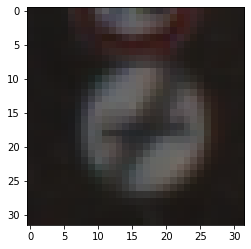

In [29]:
plt.imshow(train_imgs[0])
print(train_labels[0])
print(train_imgs.shape, train_labels.shape)

In [30]:
def gray(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

def preprocessing(img):
  img = gray(img)
  img = equalize(img)
  #now normalizing the images
  img = img/255
  return img

In [31]:
# data preprocessing
train_imgs = np.array(list(map(preprocessing, train_imgs)))
val_imgs = np.array(list(map(preprocessing, val_imgs)))
test_imgs = np.array(list(map(preprocessing, test_imgs)))

train_labels_cat = to_categorical(train_labels, 43)
val_labels_cat = to_categorical(val_labels, 43)
test_labels_cat = to_categorical(test_labels, 43)

41
(4410, 32, 32) (34799,)


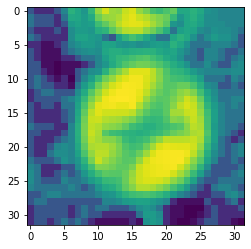

In [32]:
# new grayscale images
plt.imshow(train_imgs[0])
print(train_labels[0])
print(val_imgs.shape, train_labels.shape)

In [33]:
train_imgs = train_imgs.reshape(34799, 32, 32, 1)
val_imgs = val_imgs.reshape(4410, 32, 32, 1)
test_imgs = test_imgs.reshape(12630, 32, 32, 1)

In [42]:
# adding data augmentation layers to start of model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"), # horizontal flipping to random 50% of images
    layers.RandomRotation(0.15), # rotates input images by [-15%, 15%]
    layers.RandomZoom(0.2), # zooms in or out of image by [-20%, 20%]
  ]
)

inputs = keras.Input(shape=(32, 32, 1))
# x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding="same")(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(43, activation="softmax")(x) # because it is multi classification
model = keras.Model(inputs=inputs, outputs=outputs)

In [43]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 64)        36928     
                                                           

In [44]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
      filepath="with_padding.keras",
      monitor="val_loss"
  )
]

history = model.fit(train_imgs, train_labels_cat, epochs=30, 
                    validation_data=(val_imgs, val_labels_cat), callbacks=callbacks)

Epoch 1/30
1088/1088 [==============================] - 8s 7ms/step - loss: 1.1784 - accuracy: 0.6686 - val_loss: 0.2823 - val_accuracy: 0.9186
Epoch 2/30
1088/1088 [==============================] - 6s 5ms/step - loss: 0.2340 - accuracy: 0.9276 - val_loss: 0.1425 - val_accuracy: 0.9580
Epoch 3/30
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1413 - accuracy: 0.9556 - val_loss: 0.1127 - val_accuracy: 0.9673
Epoch 4/30
1088/1088 [==============================] - 6s 5ms/step - loss: 0.1034 - accuracy: 0.9674 - val_loss: 0.0914 - val_accuracy: 0.9703
Epoch 5/30
1088/1088 [==============================] - 6s 5ms/step - loss: 0.0816 - accuracy: 0.9733 - val_loss: 0.0990 - val_accuracy: 0.9764
Epoch 6/30
1088/1088 [==============================] - 6s 5ms/step - loss: 0.0642 - accuracy: 0.9788 - val_loss: 0.0737 - val_accuracy: 0.9776
Epoch 7/30
1088/1088 [==============================] - 5s 5ms/step - loss: 0.0568 - accuracy: 0.9815 - val_loss: 0.0841 - val_accuracy:

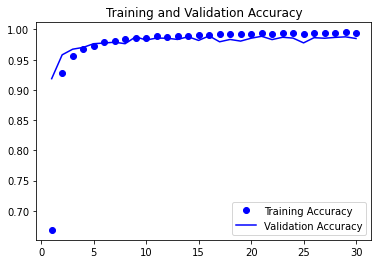

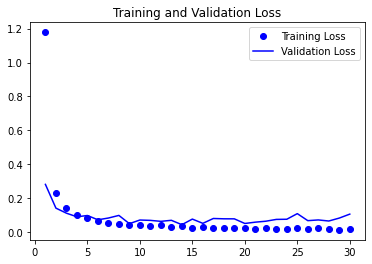

In [45]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [46]:
test_model = keras.models.load_model("with_padding.keras")
test_loss, test_acc = test_model.evaluate(test_imgs, test_labels_cat)
print(f"Test accuracy: {test_acc:.4f}")

395/395 [==============================] - 1s 3ms/step - loss: 0.2717 - accuracy: 0.9645
Test accuracy: 0.9645
